In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [88]:
np.random.seed(1)
BASIC_ARGS = """
--exp_name test
--height 6
--n_objects 12
--n_colours 2
--height 8
--width 8
--seed 2
--n_trajs 10
--n_query 1
--device cpu
"""
args = parse_args_str(PARSER, BASIC_ARGS)
print(args.exp_name)

init_start_pos = np.random.randint(0, args.height, size=(args.n_query, 2)).tolist()
print('start positions: ', init_start_pos)

env, P_a, rewards_gt, values_gt, policy_gt, feat_map = init_object_world(args)
feat_map.shape

test
start positions:  [[5, 3]]
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration


(64, 4)

In [99]:
from pathlib import Path
save_path = Path('exp_results')
e_num = 0
n_train = 8
EXP_NAMES = ['deepmaxent_random', 'deepmaxent_active', 'deepmaxent_bald']
paths = [save_path / f'{exp_name}_{e_num}' / f'{n_train-1}-train.pkl' for exp_name in EXP_NAMES]
paths[0].parent

WindowsPath('exp_results/deepmaxent_random_0')

In [ ]:
for i, s in enumerate(env.get_states()):
    if i == 16:
        break

In [ ]:
import torch
import torch.nn as nn
from src.deepmaxent_irl import demo_svf

trajs = generate_demonstrations(env, policy_gt, 
                                n_trajs=args.n_query, 
                                len_traj=args.l_traj, 
                                rand_start=True, 
                                start_pos=None)
device = torch.device(args.device)
N_STATES, _, N_ACTIONS = np.shape(P_a)
mu_D = demo_svf(trajs, N_STATES)
inputs = torch.from_numpy(feat_map).float().to(device)


In [ ]:
np.arange(0, 9).reshape((3, 3), order='F')

In [ ]:
np.sqrt(inputs.size(0)).astype(int)

In [ ]:
input_dim = 2*args.n_colours
height = np.sqrt(inputs.size(0)).astype(int)
inputs_img = inputs.view(height, height, input_dim).permute(2, 1, 0)[None,]
inputs_img[0, :, 0, 1]

In [ ]:
output_dim = 1
hiddens = [8, 8, output_dim]
layers = nn.Sequential(
    nn.Conv2d(input_dim, hiddens[0], kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Conv2d(hiddens[0], hiddens[1], kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Conv2d(hiddens[1], hiddens[2], kernel_size=3, stride=1, padding=1),
    nn.Tanh()
)

# cnn_layer = nn.Conv2d(input_dim, 8, kernel_size=3, stride=1, padding=0)
o = layers(inputs_img).squeeze()
o.permute(1, 0).reshape(-1).shape

In [ ]:
x = torch.arange(0, 9).reshape((3, 3))
x

## Maxent

In [ ]:
MAXENT_ARGS = """
--exp_name maxent_rand
--type object
--n_objects 7
--n_colours 4
--height 32
--width 32
--gamma 0.8
--act_random 0.3
--n_trajs 5
--l_traj 6
--learning_rate 0.1
--n_iters 10
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.5
--active
--seed 2
"""
args = parse_args_str(PARSER, MAXENT_ARGS)
print(args.exp_name)

history_maxent_active = run_maxent_irl(args, init_start_pos=init_start_pos)

In [ ]:
visualizer = Visualizer(history_maxent_active, file_path=None)
search_idx = 9
visualizer.draw_value_maps(search_idx)
visualizer.draw_acq_maps(search_idx)

---

## Deep Maxent

In [59]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [ ]:
DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 12
--n_colours 2
--height 8
--width 8
--gamma 0.9
--act_random 0.3
--n_trajs 10
--l_traj 8
--learning_rate 0.01
--n_iters 50
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 1.5
--hiddens 16 8
--device cuda
--active
--seed 3
--verbose 2
--architecture dnn
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_ACTIVE_ARGS)
print(args.exp_name)
history_deepmaxent_active = run_deepmaxent_irl(args, init_start_pos=None)

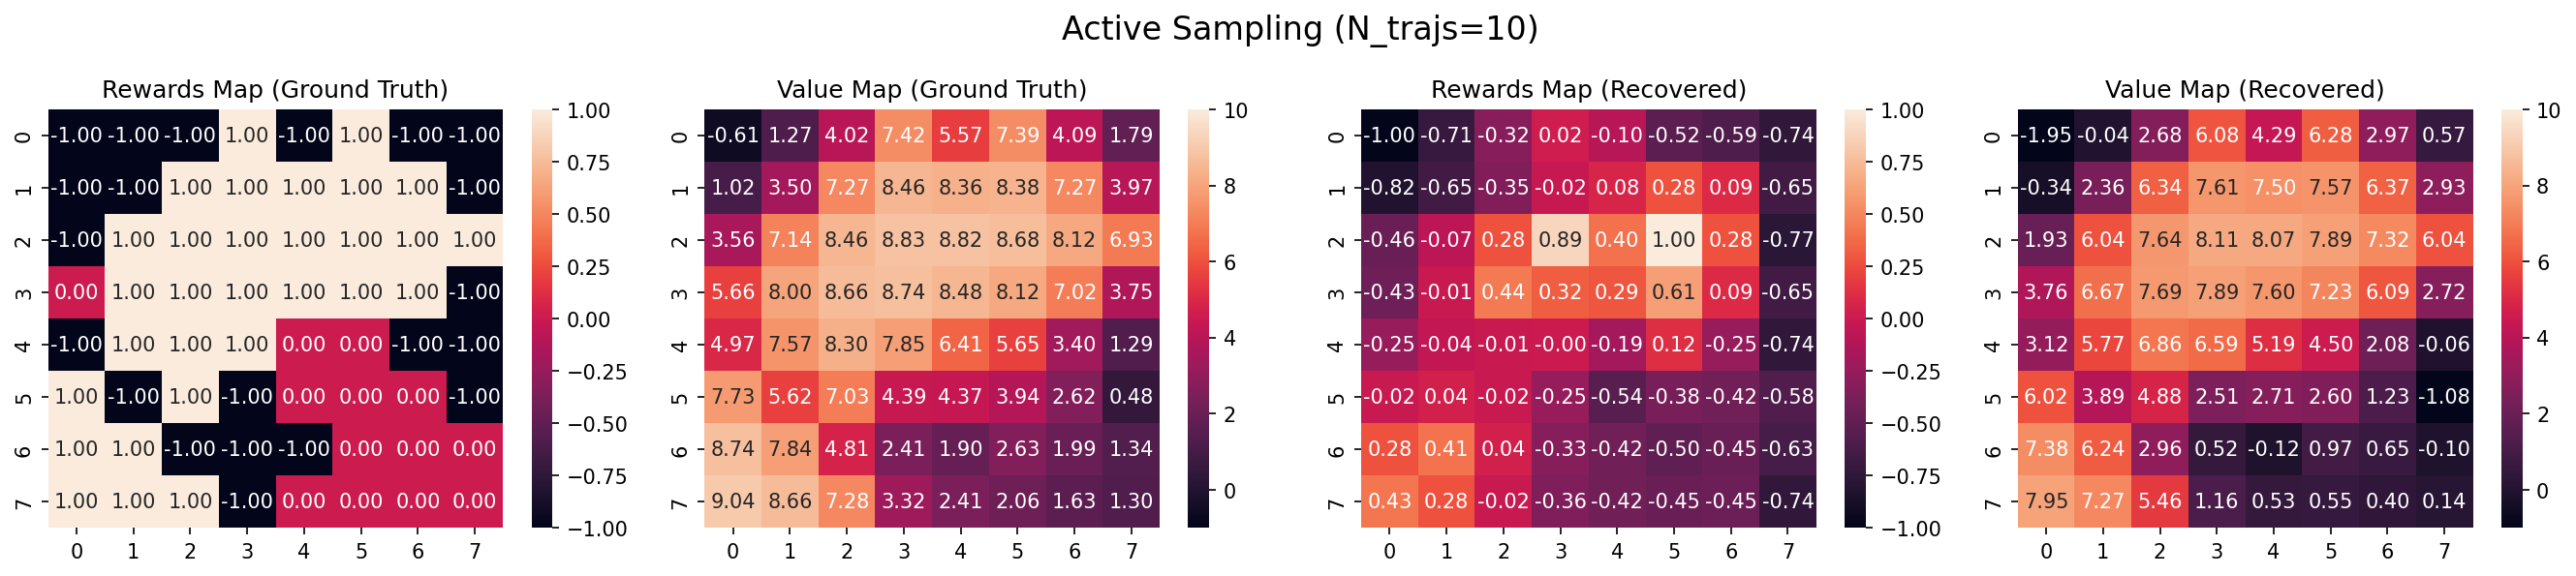

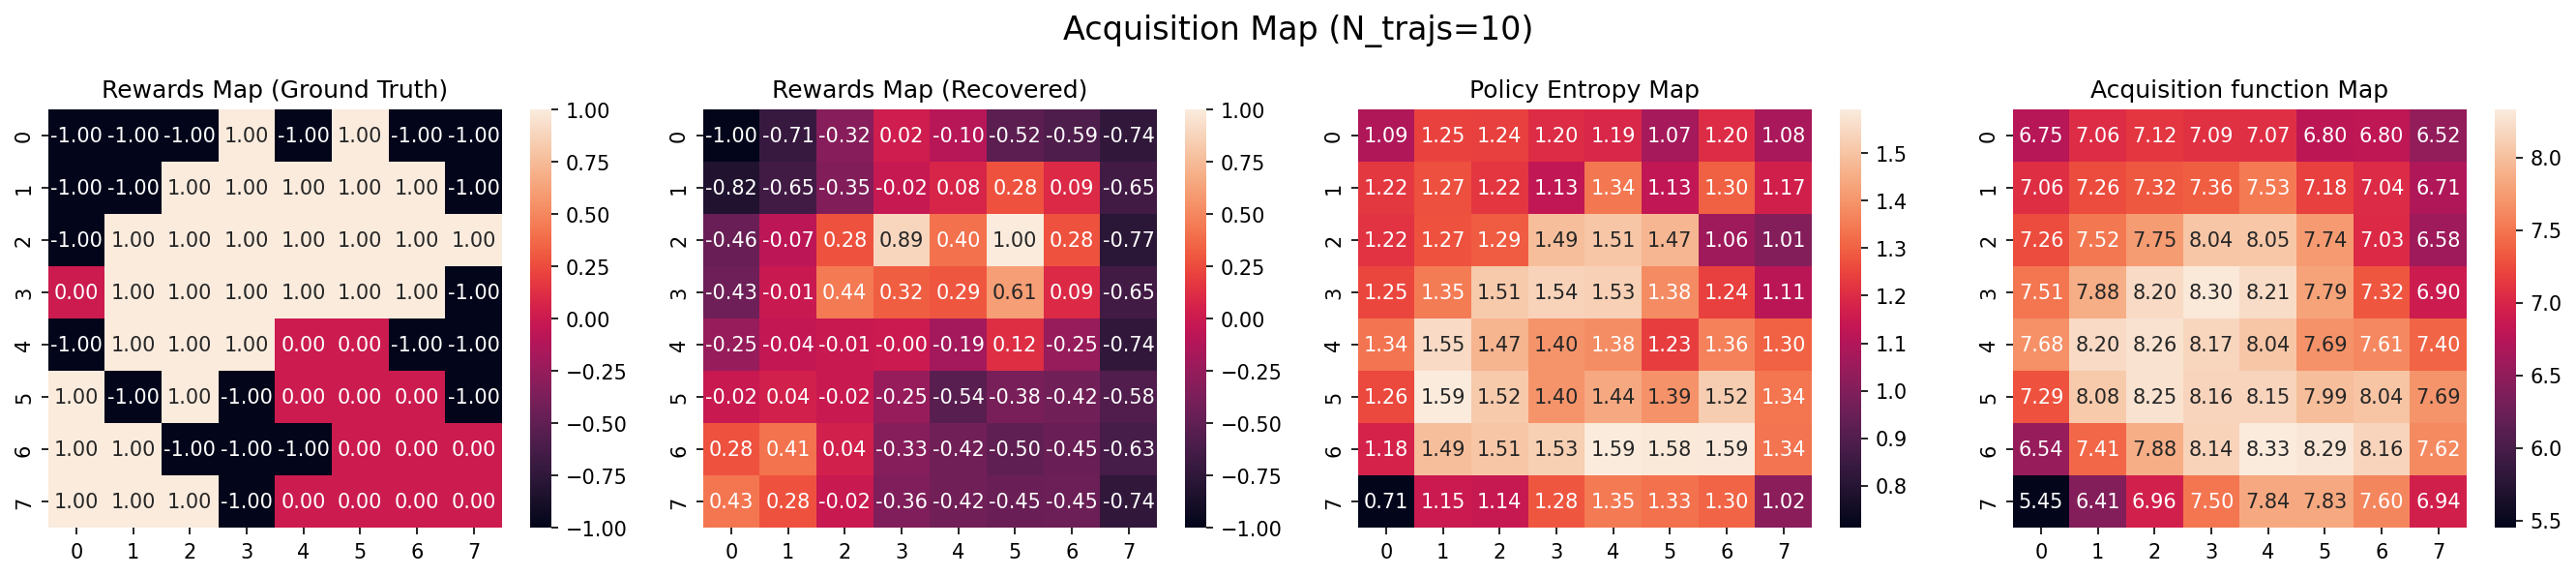

In [87]:
visualizer = Visualizer(history_deepmaxent_active, file_path=None, figsize=(18, 4), dpi=150)
n_trajs = 10
visualizer.draw_value_maps(search_idx=n_trajs)
visualizer.draw_acq_maps(search_idx=n_trajs)

In [ ]:
visualizer.objectworld_reward_policy(search_idx=n_trajs)

In [91]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 16
--n_colours 2
--height 8
--width 8
--gamma 0.9
--act_random 0.3
--n_trajs 10
--l_traj 8
--learning_rate 0.0001
--n_iters 30
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.01
--hiddens 32 32 16 8
--device cuda
--active
--seed 3
--verbose 2
--architecture cnn
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_ACTIVE_ARGS)
print(args.exp_name)
history_deepmaxent_active = run_deepmaxent_irl(args, init_start_pos=None)

deepmaxent_active
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
[INFO] Initialize trajectories
Visitation Frequency
[[2 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 2 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[INFO - n_trajs:1] Training Deep MaxEnt IRL
DeepIRLCNN(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
    )
    (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (4): Sequential(
     

  0%|          | 0/30 [00:00<?, ?it/s]

0


TypeError: conv2d() received an invalid combination of arguments - got (Sequential, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!Sequential!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!Sequential!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


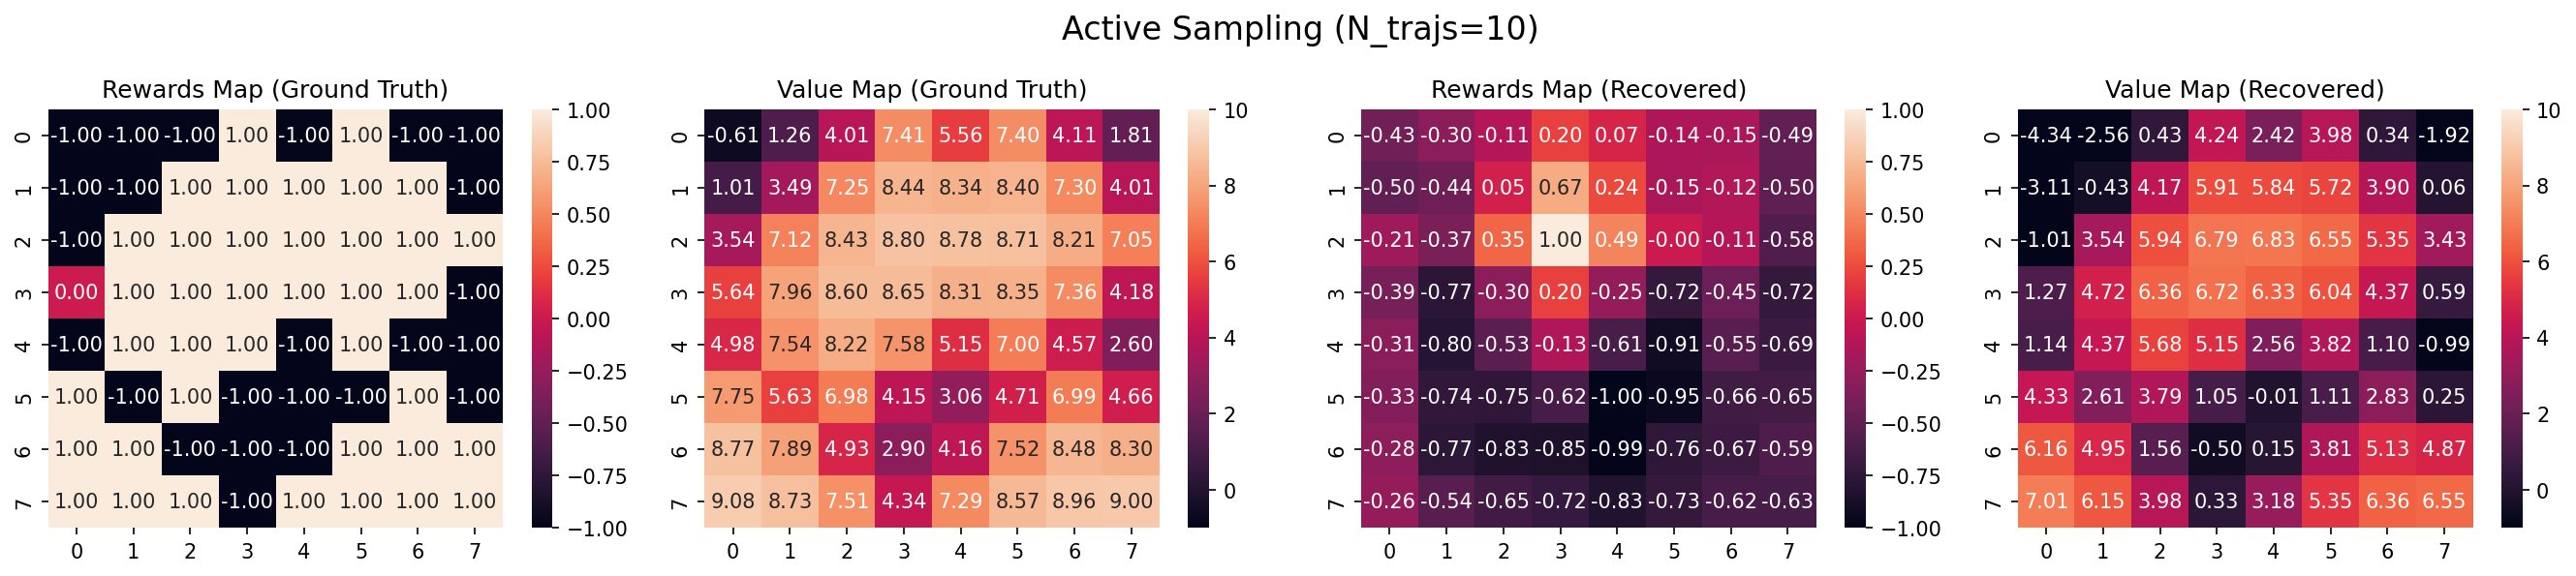

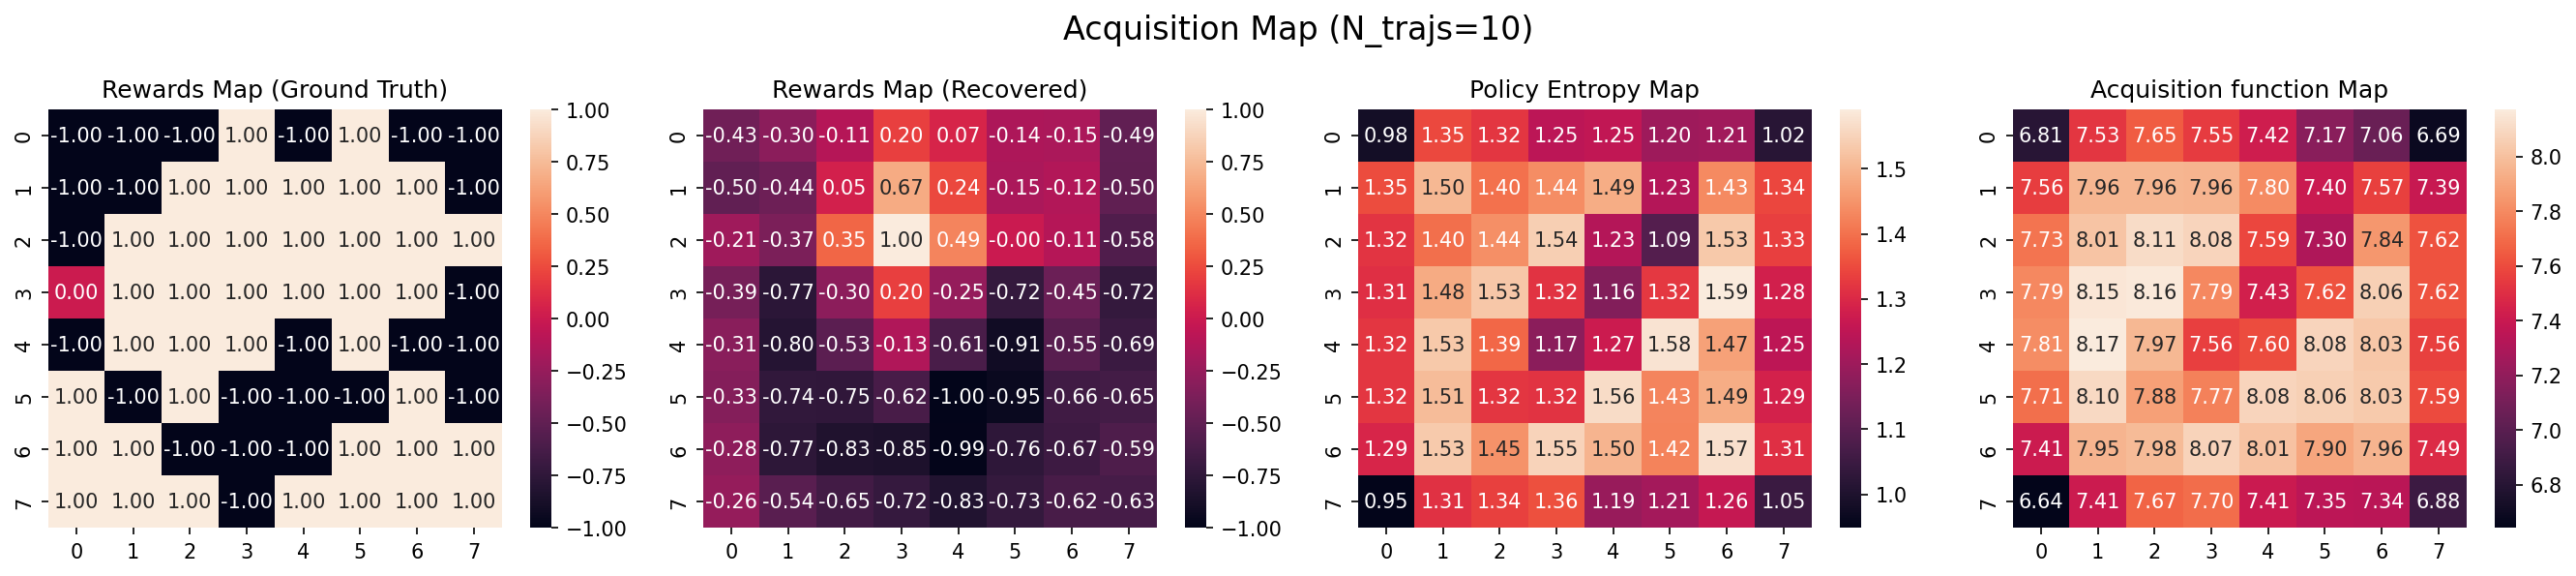

In [55]:
visualizer = Visualizer(history_deepmaxent_active, file_path=None, figsize=(18, 4), dpi=150)
n_trajs = 10
visualizer.draw_value_maps(search_idx=n_trajs)
visualizer.draw_acq_maps(search_idx=n_trajs)